In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import tensorflow as tf
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_path = '/kaggle/input/wider-face-a-face-detection-dataset'
EPOCHS = 30

2025-08-02 15:16:02.835151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754147763.121473      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754147763.197793      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(128, 128, 3), padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation="relu", padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(4, activation='sigmoid')  
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='mse', 
        metrics=['mae']
    )
    model.summary()
    return model

In [3]:
def load_wider_face_data(dataset_path, max_samples=10000):
    images = []
    bboxes = []
    annotation_file = os.path.join(dataset_path, 'wider_face_annotations/wider_face_split/wider_face_train_bbx_gt.txt')
    image_base_path = os.path.join(dataset_path, 'WIDER_train/WIDER_train/images')
    
    if not os.path.exists(annotation_file):
        print(f"Error: Annotation file not found at {annotation_file}")
        return np.array([]), np.array([])
    
    current_image = None
    box = []
    with open(annotation_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.endswith('.jpg'):
                if current_image and box and len(images) < max_samples:
                    img_path = os.path.join(image_base_path, current_image)
                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                    if img is None:
                        print(f"Warning: Could not load image {img_path}")
                        box = []
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_pil = Image.fromarray(img)
                    orig_height, orig_width = img.shape[:2]
                    
                    if len(box) > 1:
                        areas = [b[2] * b[3] for b in box]
                        largest_box = box[np.argmax(areas)]
                    else:
                        largest_box = box[0]
                    
                    x, y, w, h = largest_box
                    if w > 0 and h > 0:
                        x1 = x / orig_width
                        y1 = y / orig_height
                        x2 = (x + w) / orig_width
                        y2 = (y + h) / orig_height
                        bbox = [x1, y1, x2, y2]
                        
                        img_resized = img_pil.resize((128, 128), Image.Resampling.LANCZOS)
                        img_array = np.array(img_resized) / 255.0
                        
                        images.append(img_array)
                        bboxes.append(bbox)
                    
                current_image = line
                box = []
            elif line.isdigit():
                continue
            else:
                parts = line.split()
                if len(parts) >= 4:
                    x, y, w, h = map(int, parts[:4])
                    box.append((x, y, w, h))
    
    return np.array(images), np.array(bboxes)

I0000 00:00:1754147778.397530      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754147778.398249      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,196 (16.36 MB)

 Trainable params: 4,288,196 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1754148022.534472      98 service.cc:148] XLA service 0x7ec7c800c210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754148022.535520      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754148022.535548      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754148022.846924      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 12/250 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0919 - mae: 0.2421

I0000 00:00:1754148026.773673      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0508 - mae: 0.1793
Epoch 1: val_loss improved from inf to 0.03855, saving model to /kaggle/working/facedetectortask5.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0507 - mae: 0.1791 - val_loss: 0.0385 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 2/30
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0393 - mae: 0.1567
Epoch 2: val_loss improved from 0.03855 to 0.03591, saving model to /kaggle/working/facedetectortask5.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0393 - mae: 0.1567 - val_loss: 0.0359 - val_mae: 0.1464 - learning_rate: 9.0000e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0362 - mae: 0.1480
Epoch 3: val_loss improved from 0.03591 to 0.03480, saving model to /kaggle/working/facedetectortask5.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0362 - mae: 0.1480 - val_loss: 0.0348 - val_mae: 0.1409 - learning_rate: 8.1000e-04
Epoch 4/30
247/250 ━━━━━━

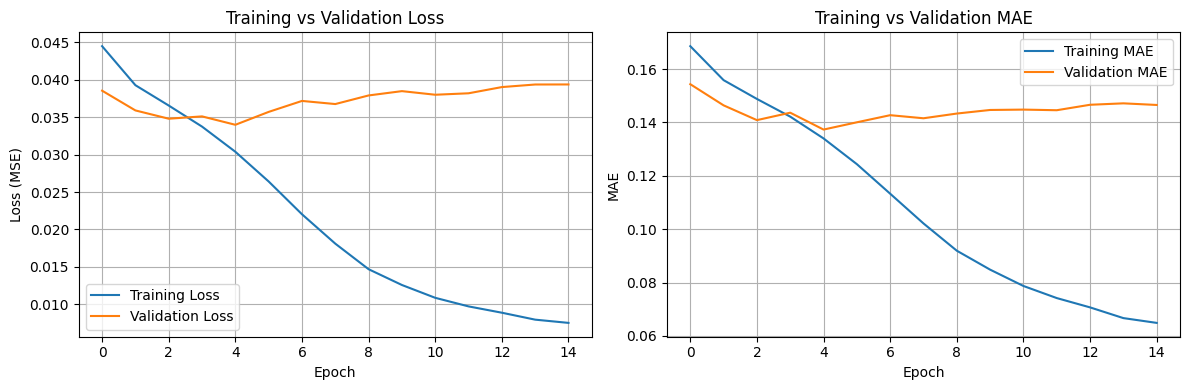


Final Training Loss (MSE): 0.0075
Final Validation Loss (MSE): 0.0394
Final Training MAE: 0.0649
Final Validation MAE: 0.1466
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369 - mae: 0.1450

Test Loss (MSE): 0.0367
Test MAE: 0.1455


In [4]:
model = build_model()
x, y = load_wider_face_data(dataset_path)
checkpoint = ModelCheckpoint(
    "/kaggle/working/facedetectortask5.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

annealer = LearningRateScheduler(lambda z: 1e-3 * 0.9 ** z)

x_train, x_tt, y_train, y_tt = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_tt, y_tt, test_size=0.2, random_state=42)

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[annealer, checkpoint, early_stopping],
    verbose=1
)

print("Loading best weights.")
model.load_weights("/kaggle/working/facedetectortask5.weights.h5")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_mae = history.history['mae'][-1]
final_val_mae = history.history['val_mae'][-1]

print(f"\nFinal Training Loss (MSE): {final_train_loss:.4f}")
print(f"Final Validation Loss (MSE): {final_val_loss:.4f}")
print(f"Final Training MAE: {final_train_mae:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")

test_loss, test_mae = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

model.save("/kaggle/working/facedetectortask5.h5")